# Load files form Drive

In [31]:
!pip install -q langchain langchain-chroma langchain-huggingface langgraph \
    sentence-transformers chromadb transformers torch

In [2]:
# Install gdown to download files from google drive
!pip install gdown

In [3]:
# Data folder URL from google drive
folder_url = "https://drive.google.com/drive/folders/1QzHjx32cNZgruG7rznmtf9DnVF4IzauO?usp=share_link"

In [4]:
import re

match = re.search(r"folders/([a-zA-Z0-9_-]+)", folder_url)
folder_id = match.group(1)
folder_id

'1QzHjx32cNZgruG7rznmtf9DnVF4IzauO'

In [5]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build

drive_service = build('drive', 'v3')

results = drive_service.files().list(
    q=f"'{folder_id}' in parents and mimeType='application/json'",
    fields="files(id, name)"
).execute()

files = results.get('files', [])
files

[{'id': '1-MD3JUGHy45oNyIP0_vHndfLkWpGn4c4', 'name': 'meetings.json'},
 {'id': '11ckNx6XQxi7q6_ShZnkK1oDcZqoq1VAg', 'name': 'incidents.json'},
 {'id': '1NQo0UZCvCfboVcLJfdj8Qk6ppWt2J9qH', 'name': 'services.json'},
 {'id': '1o-YoYRMJp1LWerWL2gCL09Rx5PFWNFoT', 'name': 'projects.json'},
 {'id': '14SxKPAdybX62Wwzc_0skEhHYXDu5ksxH', 'name': 'sprints.json'},
 {'id': '1o3G4b6vxkI5li1VyAwMUup8TGShO5QaV', 'name': 'deployments.json'},
 {'id': '13OPeQeiuRL0fG_F1ZPPrx9WyYZ40ar5c', 'name': 'jira_tickets.json'},
 {'id': '1NvqYK7TX0jauIF4dKKEnr-_nlYoFBtMv', 'name': 'employees.json'}]

In [ ]:
# Start load files from the folder
import gdown
import os

os.makedirs("json_files", exist_ok=True)

for file in files:
    file_id = file['id']
    file_name = file['name']
    output_path = f"json_files/{file_name}"

    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

print("All JSON files downloaded!")

Downloading...
From: https://drive.google.com/uc?id=1-MD3JUGHy45oNyIP0_vHndfLkWpGn4c4
To: /content/json_files/meetings.json
100%|██████████| 6.63k/6.63k [00:00<00:00, 17.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=11ckNx6XQxi7q6_ShZnkK1oDcZqoq1VAg
To: /content/json_files/incidents.json
100%|██████████| 6.45k/6.45k [00:00<00:00, 14.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NQo0UZCvCfboVcLJfdj8Qk6ppWt2J9qH
To: /content/json_files/services.json
100%|██████████| 8.81k/8.81k [00:00<00:00, 25.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o-YoYRMJp1LWerWL2gCL09Rx5PFWNFoT
To: /content/json_files/projects.json
100%|██████████| 5.80k/5.80k [00:00<00:00, 14.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=14SxKPAdybX62Wwzc_0skEhHYXDu5ksxH
To: /content/json_files/sprints.json
100%|██████████| 4.42k/4.42k [00:00<00:00, 14.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o3G4b6vxkI5li1VyAwMUup8TGShO5QaV
To: /content/json_files/deplo

All JSON files downloaded!


In [ ]:
import json
import glob
import os
from langchain.schema import Document
from pathlib import Path

def load_json_files(json_dir="json_files"):
    '''Load JSON files and convert to LangChain Documents'''
    documents = []
    json_files = glob.glob(f"{json_dir}/*.json")
    
    for file_path in json_files:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            content = json.dumps(data, indent=2)
            
            # Create Document with metadata
            doc = Document(
                page_content=content,
                metadata={
                    "source": file_path,
                    "type": "json",
                    "filename": os.path.basename(file_path),
                    "category": os.path.basename(file_path).replace('.json', '').title()
                }
            )
            documents.append(doc)
    
    print(f"✅ Loaded {len(documents)} JSON documents")
    return documents


def load_markdown_files(kb_dir="kb"):
    '''Load Markdown files from kb folder and convert to LangChain Documents'''
    documents = []
    
    # Check if kb directory exists
    if not os.path.exists(kb_dir):
        print(f"⚠️ kb folder not found at '{kb_dir}' - skipping markdown files")
        print("   Please upload the kb folder to Colab first!")
        return documents
    
    md_files = glob.glob(f"{kb_dir}/*.md")
    
    if not md_files:
        print(f"⚠️ No markdown files found in {kb_dir}/")
        return documents
    
    for file_path in md_files:
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read()
            
            # Extract title from first # heading
            title = None
            for line in content.split('\\n'):
                if line.strip().startswith('# '):
                    title = line.strip()[2:].strip()
                    break
            
            # Create Document with metadata
            doc = Document(
                page_content=content,
                metadata={
                    "source": file_path,
                    "type": "markdown",
                    "filename": os.path.basename(file_path),
                    "title": title or os.path.basename(file_path),
                    "category": "knowledge_base"
                }
            )
            documents.append(doc)
    
    print(f"✅ Loaded {len(documents)} markdown documents")
    return documents


def load_all_documents(json_dir="json_files", kb_dir="kb"):
    '''Load all documents from both JSON and Markdown sources'''
    print("\\n" + "="*80)
    print("📚 LOADING DATA FROM MULTIPLE SOURCES")
    print("="*80 + "\\n")
    
    # Load JSON files
    print("📄 Loading JSON files...")
    json_docs = load_json_files(json_dir)
    
    # Load Markdown files
    print("📝 Loading Markdown files from kb folder...")
    md_docs = load_markdown_files(kb_dir)
    
    # Combine all documents
    all_documents = json_docs + md_docs
    
    print("\\n" + "="*80)
    print(f"✅ TOTAL DOCUMENTS LOADED: {len(all_documents)}")
    print(f"   - JSON files: {len(json_docs)}")
    print(f"   - Markdown files: {len(md_docs)}")
    print("="*80 + "\\n")
    
    return all_documents


# Load all documents
docs = load_all_documents()

Loaded 8 documents


# Convert files to LangChain Document

In [32]:
import warnings
warnings.filterwarnings('ignore')

from typing import TypedDict, List
import json
import glob

from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, END

from transformers import pipeline
import torch

print("✓ All libraries imported")
print(f"✓ GPU available: {torch.cuda.is_available()}")

✓ All libraries imported
✓ GPU available: True


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Split documents into chunks
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\\n\\n", "\\n", " ", ""]
)

split_docs = splitter.split_documents(docs)
print(f"✅ Split {len(docs)} documents into {len(split_docs)} chunks")

# Display samples from each type
print("\\n" + "="*80)
print("📋 SAMPLE CHUNKS:")
print("="*80)

# Show JSON sample
json_samples = [d for d in split_docs if d.metadata.get('type') == 'json']
if json_samples:
    sample = json_samples[0]
    print(f"\\n[JSON Sample - {sample.metadata['filename']}]")
    print(f"Category: {sample.metadata['category']}")
    print(f"Content preview: {sample.page_content[:200]}...\\n")

# Show Markdown sample
md_samples = [d for d in split_docs if d.metadata.get('type') == 'markdown']
if md_samples:
    sample = md_samples[0]
    print(f"[Markdown Sample - {sample.metadata['filename']}]")
    print(f"Title: {sample.metadata.get('title', 'N/A')}")
    print(f"Content preview: {sample.page_content[:200]}...\\n")

print("="*80)

In [ ]:
raw_documents = []

for file in glob.glob("json_files/*.json"):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        raw_documents.append(str(data))

print(f"✓ Loaded {len(raw_documents)} JSON files")

docs = [Document(page_content=text) for text in raw_documents]

splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

split_docs = splitter.split_documents(docs)
print(f"✓ Split into {len(split_docs)} chunks")

✓ Loaded 8 JSON files
✓ Split into 136 chunks


In [ ]:
# Use Flan-T5 - Google's free, open-source model
# Works great for Q&A tasks

print("Loading Flan-T5 model (this takes ~1 minute first time)...")

# Create pipeline
pipe = pipeline(
    "text2text-generation",
    model="google/flan-t5-large",  # 780M params, better quality
    max_length=512,
    device=0 if torch.cuda.is_available() else -1
)

llm = HuggingFacePipeline(pipeline=pipe)

print("✓ Flan-T5 model loaded (100% free, no API needed)")
print(f"✓ Running on: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Loading Flan-T5 model (this takes ~1 minute first time)...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


✓ Flan-T5 model loaded (100% free, no API needed)
✓ Running on: GPU


In [ ]:
# Initialize embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

# Create vector store with ALL documents (JSON + Markdown)
vectorstore = Chroma.from_documents(
    documents=split_docs,
    embedding=embeddings,
    collection_name="hr_nexus_rag"
)

print(f"✅ Vector store created with {len(split_docs)} document chunks")
print(f"   - Includes {len([d for d in split_docs if d.metadata['type']=='json'])} JSON chunks")
print(f"   - Includes {len([d for d in split_docs if d.metadata['type']=='markdown'])} Markdown chunks")
print(f"   - Running on: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✓ Vector store created with 136 documents


In [36]:
class RAGState(TypedDict):
    question: str
    query_type: str
    retrieved_docs: List[Document]
    context: str
    answer: str
    sources: List[str]

print("✓ State defined")

✓ State defined


In [37]:
def classify_query(state: RAGState) -> RAGState:
    q = state["question"].lower()

    if any(w in q for w in ['project', 'projects', 'deliverable']):
        qt = 'project'
    elif any(w in q for w in ['sprint', 'iteration', 'velocity']):
        qt = 'sprint'
    elif any(w in q for w in ['incident', 'outage', 'issue', 'bug']):
        qt = 'incident'
    elif any(w in q for w in ['jira', 'ticket', 'task', 'story']):
        qt = 'jira'
    elif any(w in q for w in ['meeting', 'discussion', 'decision']):
        qt = 'meeting'
    elif any(w in q for w in ['deployment', 'deploy', 'release']):
        qt = 'deployment'
    else:
        qt = 'general'

    print(f"📊 Type: {qt}")
    return {"query_type": qt}


def retrieve_documents(state: RAGState) -> RAGState:
    k = 5 if state["query_type"] == 'general' else 3
    docs = vectorstore.similarity_search(state["question"], k=k)
    print(f"📚 Retrieved {len(docs)} docs")
    return {"retrieved_docs": docs}


def build_context(state: RAGState) -> RAGState:
    docs = state["retrieved_docs"]
    context = "\\n\\n".join([f"[Doc {i+1}] {d.page_content}" for i, d in enumerate(docs)])
    sources = [f"Doc {i+1}" for i in range(len(docs))]
    return {"context": context, "sources": sources}


def generate_answer(state: RAGState) -> RAGState:
    question = state["question"]
    context = state["context"]

    # Flan-T5 works best with simple, direct prompts
    prompt = f"""Answer the question based on the context.

Context: {context}

Question: {question}

Answer:"""

    print("🤖 Generating answer...")
    answer = llm.invoke(prompt)

    return {"answer": answer}

print("✓ Nodes defined")

✓ Nodes defined


In [38]:
workflow = StateGraph(RAGState)

workflow.add_node("classify", classify_query)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("build_context", build_context)
workflow.add_node("generate", generate_answer)

workflow.set_entry_point("classify")
workflow.add_edge("classify", "retrieve")
workflow.add_edge("retrieve", "build_context")
workflow.add_edge("build_context", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

print("✓ Workflow ready")

✓ Workflow ready


In [39]:
def query_rag_system(question: str, show_sources: bool = True):
    print(f"\\n{'='*80}")
    print(f"Q: {question}")
    print(f"{'='*80}\\n")

    result = app.invoke({
        "question": question,
        "query_type": "",
        "retrieved_docs": [],
        "context": "",
        "answer": "",
        "sources": []
    })

    print("\\n📝 ANSWER:")
    print(result['answer'])

    if show_sources and result.get('sources'):
        print(f"\\n{'─'*80}")
        print(f"📚 SOURCES ({len(result['sources'])}):")
        print(f"{'─'*80}")
        for i, doc in enumerate(result['retrieved_docs'], 1):
            print(f"\\n[{i}] {doc.page_content[:200]}...")

    print(f"\\n{'='*80}\\n")
    return result

print("✓ Ready to use!")

✓ Ready to use!


In [40]:
query_rag_system("What projects are currently in progress?")

Token indices sequence length is longer than the specified maximum sequence length for this model (756 > 512). Running this sequence through the model will result in indexing errors


\n================================================================================
Q: What projects are currently in progress?
================================================================================\n
📊 Type: project
📚 Retrieved 3 docs
🤖 Generating answer...
\n📝 ANSWER:
['Onboarding Improvements', 'harri/onboarding-service', 'harri/frontend-app', 'Node.js', 'MongoDB', 'React', 'Redis']
\n────────────────────────────────────────────────────────────────────────────────
📚 SOURCES (3):
────────────────────────────────────────────────────────────────────────────────
\n[1] Retrospective', 'type': 'retrospective', 'date': '2025-06-22T14:00:00Z', 'duration_minutes': 90, 'attendees': ['noor_j', 'ahmed_ali', 'fatima_k', 'sarah_odeh', 'khaled_m', 'adam_s', 'lina_s', 'youssef...
\n[2] Retrospective', 'type': 'retrospective', 'date': '2025-06-22T14:00:00Z', 'duration_minutes': 90, 'attendees': ['noor_j', 'ahmed_ali', 'fatima_k', 'sarah_odeh', 'khaled_m', 'adam_s', 'lina_s', 'youssef...
\n[

{'question': 'What projects are currently in progress?',
 'query_type': 'project',
 'retrieved_docs': [Document(id='aa66bbe6-9f3e-427c-b4c6-f9bb2d3bdaac', metadata={}, page_content="Retrospective', 'type': 'retrospective', 'date': '2025-06-22T14:00:00Z', 'duration_minutes': 90, 'attendees': ['noor_j', 'ahmed_ali', 'fatima_k', 'sarah_odeh', 'khaled_m', 'adam_s', 'lina_s', 'youssef_h', 'leen_q', 'omar_s', 'maya_t', 'rami_b', 'layla_r', 'tariq_y'], 'agenda': ['What went well', 'What could be improved', 'Action items for next sprint'], 'notes': 'Payment integration completed successfully. Frontend redesign received positive feedback. DevOps tasks took longer than estimated."),
  Document(id='9df67195-7d9f-409f-82c4-0e6f2db596d6', metadata={}, page_content="Retrospective', 'type': 'retrospective', 'date': '2025-06-22T14:00:00Z', 'duration_minutes': 90, 'attendees': ['noor_j', 'ahmed_ali', 'fatima_k', 'sarah_odeh', 'khaled_m', 'adam_s', 'lina_s', 'youssef_h', 'leen_q', 'omar_s', 'maya_t', 'r

In [41]:
query_rag_system("What are the high priority JIRA tickets?")


\n================================================================================
Q: What are the high priority JIRA tickets?
================================================================================\n
📊 Type: jira
📚 Retrieved 3 docs
🤖 Generating answer...
\n📝 ANSWER:
['HARRI-131', 'HARRI-132', 'HARRI-137', 'HARRI-138', 'HARRI-139', 'HARRI-140', 'HARRI-141', 'HARRI-144', 'HARRI-145']
\n────────────────────────────────────────────────────────────────────────────────
📚 SOURCES (3):
────────────────────────────────────────────────────────────────────────────────
\n[1] internationalization, and infrastructure upgrades', 'total_story_points': 89, 'completed_story_points': 0, 'team_velocity': 85, 'tickets': ['HARRI-131', 'HARRI-132', 'HARRI-136', 'HARRI-137', 'HARRI-1...
\n[2] internationalization, and infrastructure upgrades', 'total_story_points': 89, 'completed_story_points': 0, 'team_velocity': 85, 'tickets': ['HARRI-131', 'HARRI-132', 'HARRI-136', 'HARRI-137', 'HARRI-1...
\n[3] 

{'question': 'What are the high priority JIRA tickets?',
 'query_type': 'jira',
 'retrieved_docs': [Document(id='71986e9a-1ee2-471b-9ed7-ed3df8fa67a3', metadata={}, page_content="internationalization, and infrastructure upgrades', 'total_story_points': 89, 'completed_story_points': 0, 'team_velocity': 85, 'tickets': ['HARRI-131', 'HARRI-132', 'HARRI-136', 'HARRI-137', 'HARRI-138', 'HARRI-139', 'HARRI-140', 'HARRI-141', 'HARRI-144', 'HARRI-145'], 'burndown': [], 'retrospective_notes': None}, {'id': 'sprint-23', 'name': 'Sprint 23', 'start_date': '2025-06-09T00:00:00Z', 'end_date': '2025-06-22T23:59:59Z', 'status': 'completed', 'goal': 'Complete payment gateway"),
  Document(id='227c2e67-a851-4f2c-9ded-a301c0990446', metadata={}, page_content="internationalization, and infrastructure upgrades', 'total_story_points': 89, 'completed_story_points': 0, 'team_velocity': 85, 'tickets': ['HARRI-131', 'HARRI-132', 'HARRI-136', 'HARRI-137', 'HARRI-138', 'HARRI-139', 'HARRI-140', 'HARRI-141', 'HAR

In [ ]:
# Test the system with a project query
query_rag_system("What projects are currently in progress and what are their statuses?")

In [ ]:
# Query about sprints
query_rag_system("Tell me about the current sprint. What are the goals and timeline?")

In [ ]:
# Query about incidents
query_rag_system("Have there been any recent incidents? What were they and how were they resolved?")

In [ ]:
# Query about JIRA tickets
query_rag_system("What are the high-priority JIRA tickets that need attention?")

In [ ]:
# Query about team
query_rag_system("Who are the key team members and what are their roles?")

In [ ]:
# Query about deployments
query_rag_system("What deployments have been made recently and were they successful?")

In [42]:
print("🤖 Interactive RAG System (100% Free)")
print("Type 'exit' to stop\\n")

while True:
    q = input("\\n❓ Question: ").strip()
    if q.lower() in ['exit', 'quit', '']:
        print("\\n👋 Bye!")
        break
    try:
        query_rag_system(q, show_sources=False)
    except Exception as e:
        print(f"❌ Error: {e}")

🤖 Interactive RAG System (100% Free)
Type 'exit' to stop\n
\n❓ Question: What deployments have been made recently and were they successful?
\n================================================================================
Q: What deployments have been made recently and were they successful?
================================================================================\n
📊 Type: deployment
📚 Retrieved 3 docs
🤖 Generating answer...
\n📝 ANSWER:
['DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'DevOps Excellence', 'deployed_by: adam_s', 'deployed_by: adam_s', 

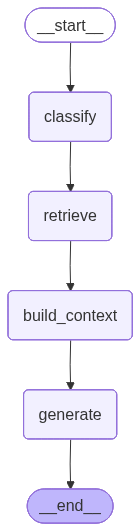

✓ Workflow visualization displayed above


In [43]:
# Visualize the LangGraph workflow
try:
    from IPython.display import Image, display

    # Generate and display the graph
    graph_image = app.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    print("✓ Workflow visualization displayed above")
except Exception as e:
    print(f"Could not visualize graph: {e}")
    print("\\nWorkflow structure:")
    print("  1. classify (Classify query type)")
    print("  2. retrieve (Retrieve relevant documents)")
    print("  3. build_context (Build context from documents)")
    print("  4. generate (Generate answer with LLM)")

In [46]:
# Enhanced version with conversation memory
from langgraph.checkpoint.memory import MemorySaver

# Recompile with memory
memory = MemorySaver()
app_with_memory = workflow.compile(checkpointer=memory)

def query_with_memory(question: str, thread_id: str = "default"):
    '''Query with conversation memory'''
    config = {"configurable": {"thread_id": thread_id}}

    result = app_with_memory.invoke({
        "question": question,
        "query_type": "",
        "retrieved_docs": [],
        "context": "",
        "answer": "",
        "sources": []
    }, config)

    print(f"\\nQ: {question}")
    print(f"A: {result['answer']}\\n")
    return result

print("✓ Memory-enabled RAG system ready")
print("Use: query_with_memory('your question', thread_id='session1')")

✓ Memory-enabled RAG system ready
Use: query_with_memory('your question', thread_id='session1')


In [47]:
import time

def benchmark_query(question: str, num_runs: int = 3):
    '''Benchmark query performance'''
    print(f"\\n🔬 Benchmarking: '{question}'")
    print(f"Running {num_runs} times...\\n")

    times = []
    for i in range(num_runs):
        start = time.time()
        app.invoke({
            "question": question,
            "query_type": "",
            "retrieved_docs": [],
            "context": "",
            "answer": "",
            "sources": []
        })
        elapsed = time.time() - start
        times.append(elapsed)
        print(f"Run {i+1}: {elapsed:.2f}s")

    print(f"\\n📈 Average: {sum(times)/len(times):.2f}s")
    print(f"📈 Min: {min(times):.2f}s")
    print(f"📈 Max: {max(times):.2f}s")

# Example: benchmark_query("What projects are active?")
print("✓ Benchmark function ready")

✓ Benchmark function ready
